In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [11]:
# Load the data
df = pd.read_csv('drought_training_data.csv')

df.head()

,Water Potential (Mpa),339,341,342,344,345,346,348,349,351,...,2497,2499,2501,2503,2505,2507,2509,2511,2514,2516
0,-0.089632,0.1481,0.1818,0.1748,0.1486,0.1045,0.0782,0.0904,0.0830,0.1101,...,0.0344,0.0332,0.0347,0.0323,0.0308,0.0360,0.0346,0.0320,0.0328,0.0344
1,-0.148237,0.1422,0.1360,0.1384,0.1283,0.1103,0.0967,0.1014,0.1040,0.0934,...,0.0557,0.0560,0.0589,0.0560,0.0551,0.0563,0.0554,0.0533,0.0547,0.0528
2,-0.128243,0.0978,0.0920,0.1038,0.0981,0.0793,0.0613,0.0477,0.0520,0.0545,...,0.0314,0.0280,0.0252,0.0269,0.0275,0.0293,0.0311,0.0284,0.0279,0.0294
3,-0.164785,0.1422,0.1360,0.1538,0.1283,0.1241,0.1161,0.1074,0.0876,0.0831,...,0.0466,0.0456,0.0473,0.0484,0.0452,0.0428,0.0450,0.0486,0.0425,0.0479
4,-0.326122,0.1333,0.1280,0.1307,0.0981,0.1034,0.0838,0.0776,0.0767,0.0779,...,0.0375,0.0373,0.0347,0.0323,0.0330,0.0360,0.0369,0.0344,0.0340,0.0405


In [12]:
# ---------------------------------
# Define predictors and response
# ---------------------------------
predictors = df.drop(columns = ['Water Potential (Mpa)'])
response = df['Water Potential (Mpa)']

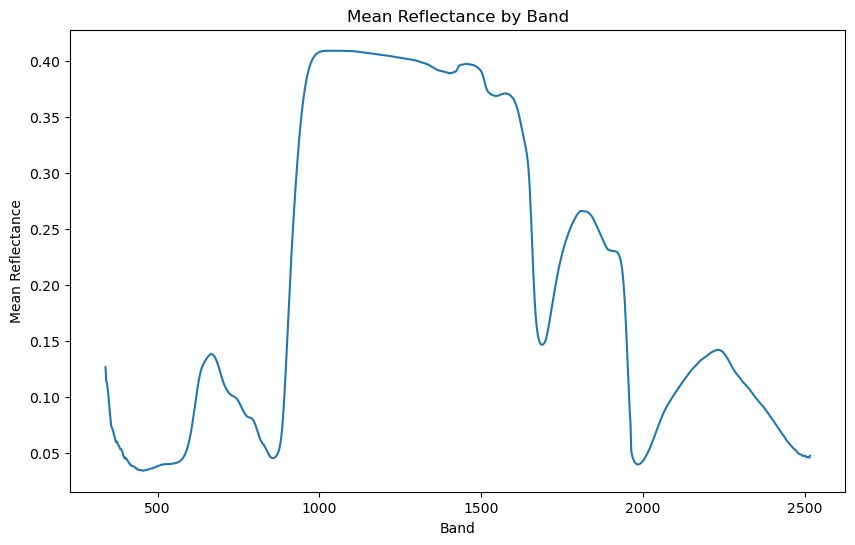

In [16]:
# Compute the step size required to have 994 bands within the range
start_band = 339
end_band = 2516
num_bands = 994
step_size = (end_band - start_band) / (num_bands - 1)

# Create a numpy array of the band values with 994 bands
bands = np.arange(start_band, end_band + step_size, step_size)

# Plot a line plot where the x-axis is the bands and y-axis is the mean of the features
plt.figure(figsize=(10, 6))
plt.plot(bands, predictors.mean(axis=0))
plt.xlabel('Band')
plt.ylabel('Mean Reflectance')
plt.title('Mean Reflectance by Band')
plt.show()

# Savitzky-Golay filter

In [17]:
from scipy import signal
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline

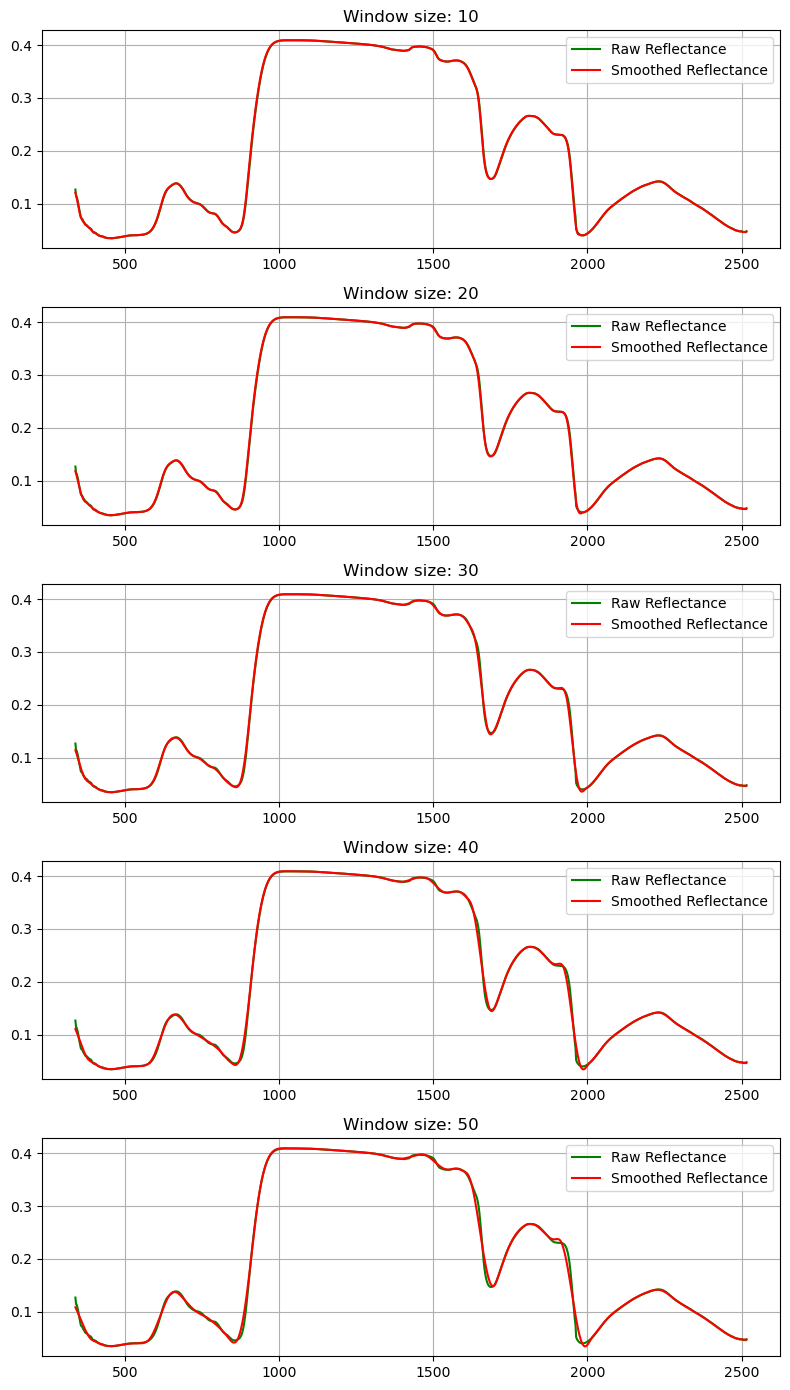

In [19]:
ig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 
# define window sizes 10, 20, 30, 40, 50
for w_size in [10, 20, 30, 40, 50]:    
    X_smooth = signal.savgol_filter(predictors, w_size, 3, mode="nearest")
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smooth.mean(axis=0), label="Smoothed Reflectance", color="red")
    ax[i].set_title("Window size: " + str(w_size))
    ax[i].legend()
    ax[i].grid(True)
    i+=1

plt.tight_layout()        
plt.show() 

# Gaussian Kernel Smoother

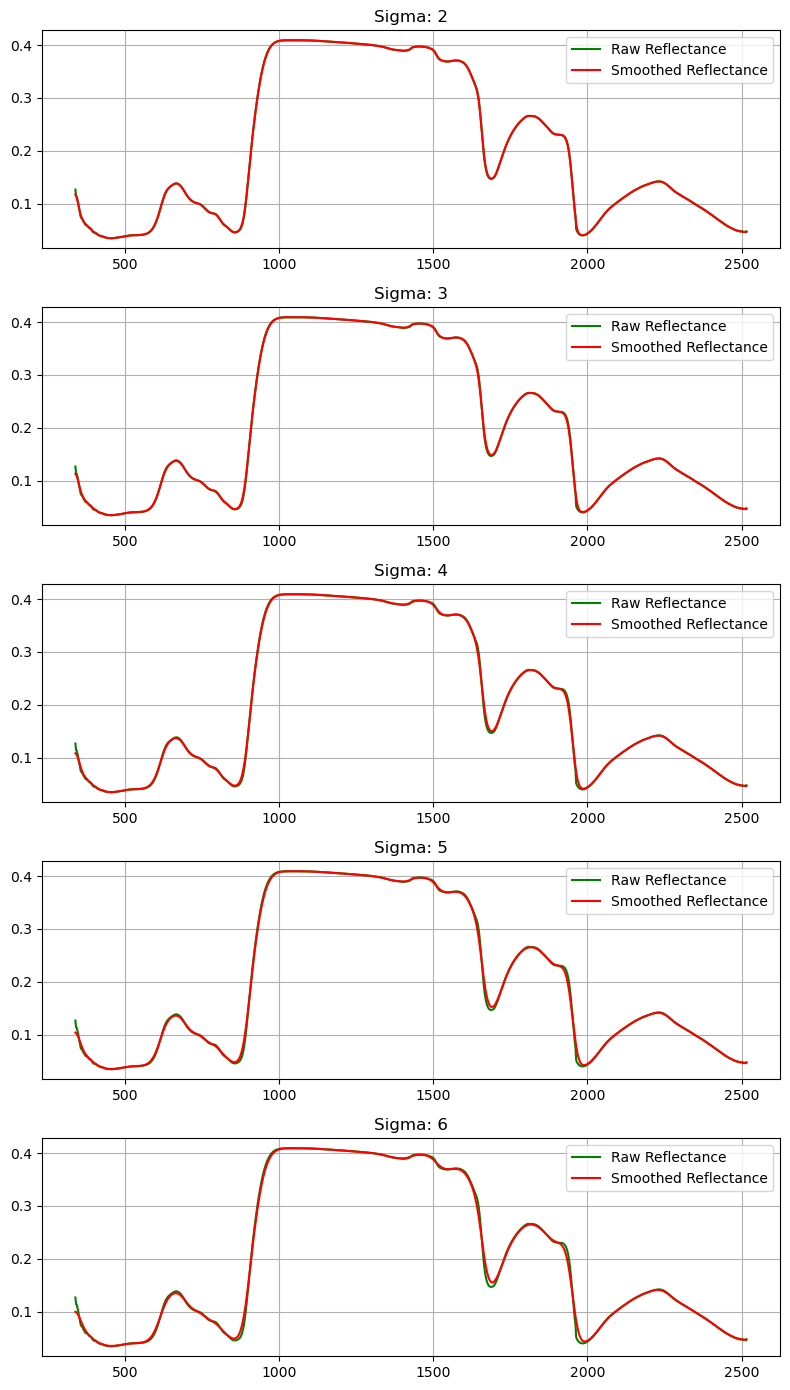

In [20]:
fig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 

# define sigma values 1, 2, 3, 4, 5
for sigma in [2, 3, 4, 5, 6]:    
    X_smooth = gaussian_filter1d(predictors.mean(axis=0), sigma)
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smooth, label="Smoothed Reflectance", color="red")
    ax[i].set_title("Sigma: " + str(sigma))
    ax[i].legend()
    ax[i].grid(True)
    i+=1

plt.tight_layout()        
plt.show() 

# Kalman filter

In [22]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=45fa0238d1a8255e399db173af8d1548a09bec629ee40b67ffb4ff19091a8c08
  Stored in directory: /Users/trangtran/Library/Caches/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


ValueError: x and y must have same first dimension, but have shapes (994,) and (53,)

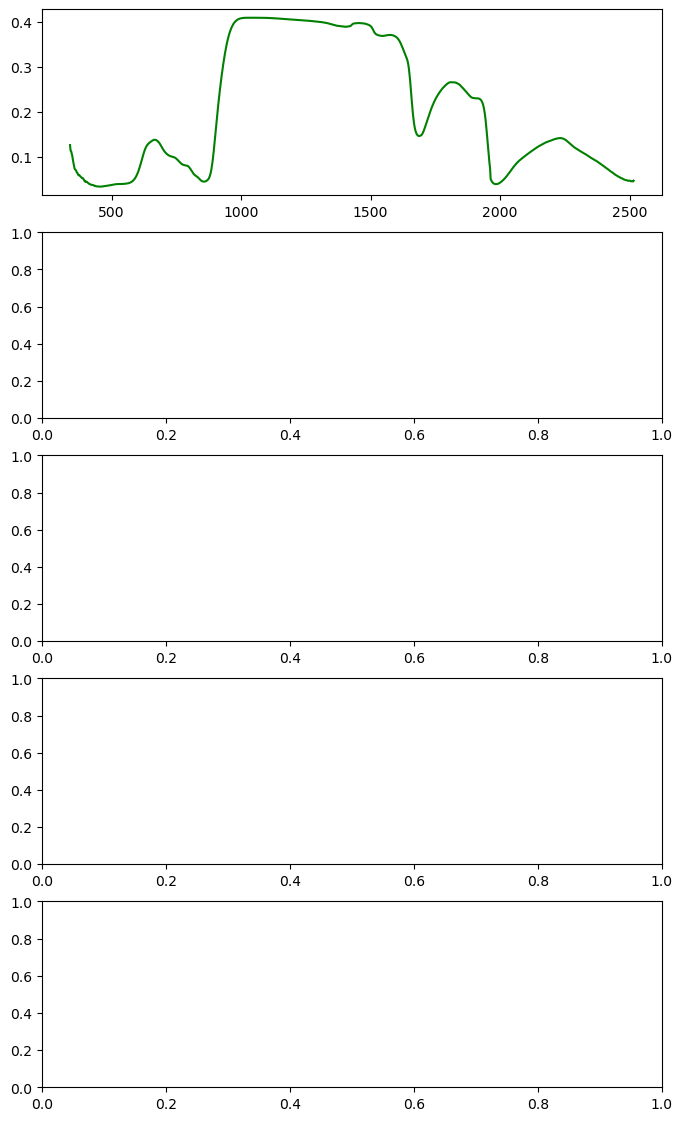

In [31]:
# Initialize Kalman filter parameters
from filterpy.kalman import KalmanFilter

# Convert predictors to a NumPy array
predictors_array = predictors.to_numpy()

# Plotting
fig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 

# Define sigma values
sigmas = [2, 3, 4, 5, 6]

# Loop over sigma values
for sigma in sigmas:    
    # Smooth the data using the Kalman filter
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = np.array([[1, 1], [0, 1]])
    kf.H = np.array([[1, 0]])
    kf.Q = np.eye(2) * 0.01
    kf.R = np.eye(1) * 0.1
    kf.x = np.array([0, 0])
    kf.P = np.eye(2)
    
    # Clear X_smoothed for each iteration
    X_smoothed = []
    
    for measurement in predictors.T:
        kf.predict()
        kf.update(measurement)
        X_smoothed.append(kf.x[0])
    
    # Plot original and smoothed data
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smoothed, label="Smoothed Reflectance (Kalman Filter)", color="red")
    ax[i].set_title("Sigma: " + str(sigma))
    ax[i].legend()
    ax[i].grid(True)
    i += 1

plt.tight_layout()        
plt.show()

# Wiener Filter

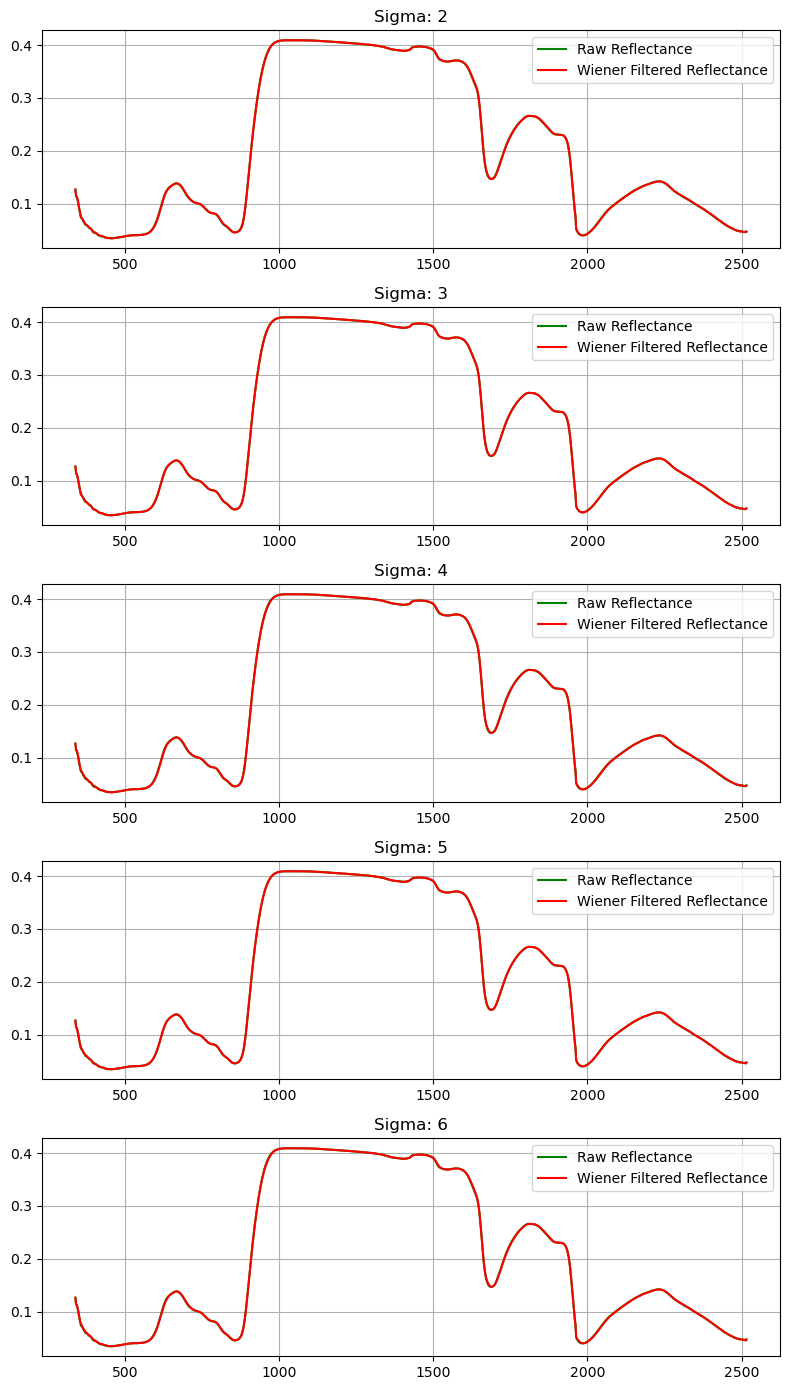

In [32]:
from scipy.signal import wiener

# Plotting
fig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 

# Define sigma values
sigmas = [2, 3, 4, 5, 6]

# Loop over sigma values
for sigma in sigmas:    
    # Apply Wiener filtering
    X_smooth = wiener(predictors.mean(axis=0), mysize=sigma)
    
    # Plot original and smoothed data
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smooth, label="Wiener Filtered Reflectance", color="red")
    ax[i].set_title("Sigma: " + str(sigma))
    ax[i].legend()
    ax[i].grid(True)
    i += 1

plt.tight_layout()        
plt.show()


# Median Filter

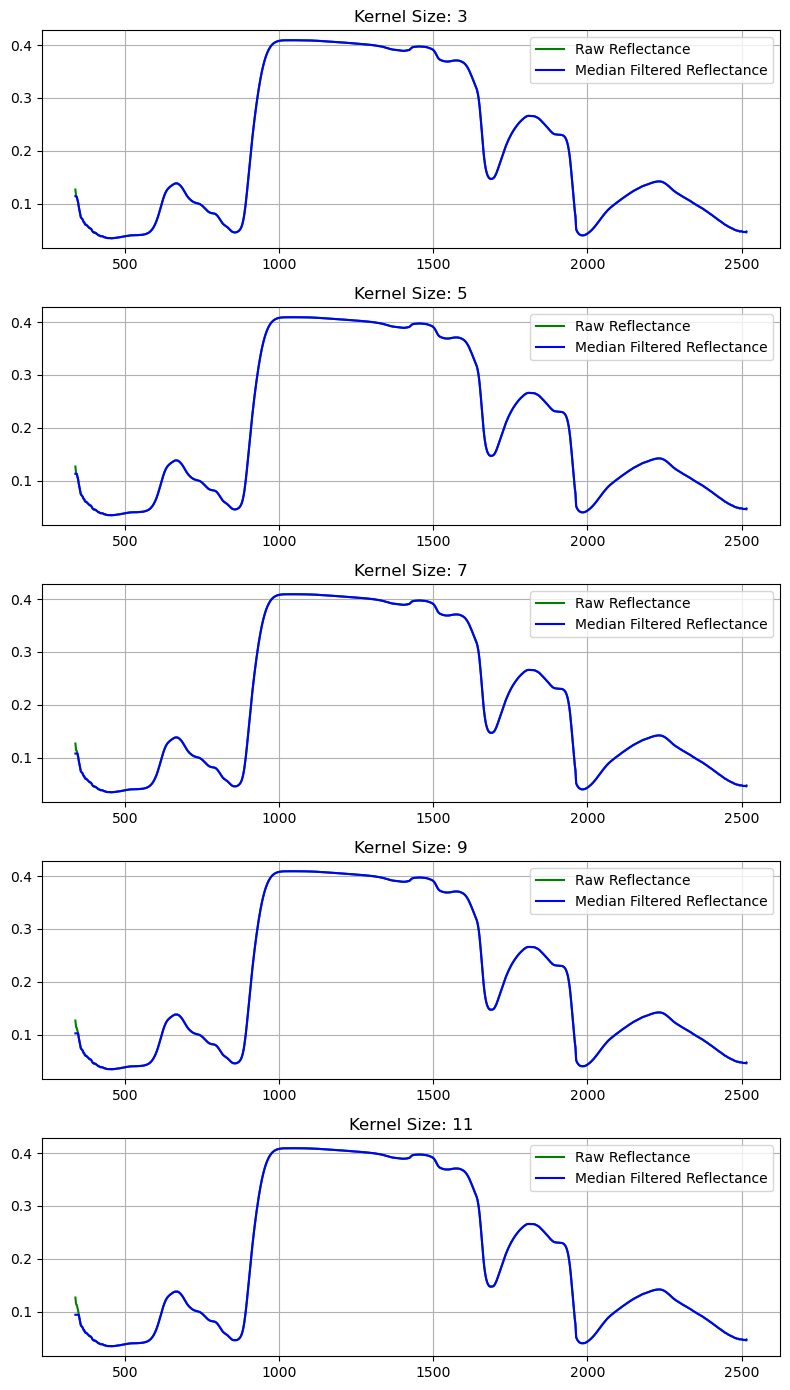

In [33]:
from scipy.signal import medfilt

fig, ax = plt.subplots(5, figsize=(8, 14))
i = 0 

# Define kernel sizes for median filter
kernel_sizes = [3, 5, 7, 9, 11]

# Loop over kernel sizes
for kernel_size in kernel_sizes:    
    # Apply median filtering
    X_smooth = medfilt(predictors.mean(axis=0), kernel_size)
    
    # Plot original and smoothed data
    ax[i].plot(bands, predictors.mean(axis=0), label="Raw Reflectance", color="green")
    ax[i].plot(bands, X_smooth, label="Median Filtered Reflectance", color="blue")
    ax[i].set_title("Kernel Size: " + str(kernel_size))
    ax[i].legend()
    ax[i].grid(True)
    i += 1

plt.tight_layout()        
plt.show()
